In [4]:
!pip install -q ultralytics xmltodict

import os
import shutil
import xmltodict
from glob import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from ultralytics import YOLO


In [5]:
# Define dataset base path and label mappings
base_path = "/kaggle/input/face-mask-detection"
CLASS_MAP = {'with_mask': 0, 'mask_weared_incorrect': 1, 'without_mask': 2}

print("Sample annotations:", os.listdir(f"{base_path}/annotations")[:3])
print("Sample images:", os.listdir(f"{base_path}/images")[:3])


Sample annotations: ['maksssksksss737.xml', 'maksssksksss410.xml', 'maksssksksss537.xml']
Sample images: ['maksssksksss810.png', 'maksssksksss848.png', 'maksssksksss145.png']


In [6]:
os.makedirs("/kaggle/working/labels", exist_ok=True)

def convert_bbox(size, box):
    dw, dh = 1. / size[0], 1. / size[1]
    x_center = (box[0] + box[1]) / 2.0 * dw
    y_center = (box[2] + box[3]) / 2.0 * dh
    width = (box[1] - box[0]) * dw
    height = (box[3] - box[2]) * dh
    return (x_center, y_center, width, height)

for xml_file in glob(os.path.join(base_path, "annotations", "*.xml")):
    with open(xml_file) as f:
        doc = xmltodict.parse(f.read())

    filename = doc['annotation']['filename']
    img_w = int(doc['annotation']['size']['width'])
    img_h = int(doc['annotation']['size']['height'])
    objects = doc['annotation'].get('object', [])
    if not isinstance(objects, list):
        objects = [objects]

    lines = []
    for obj in objects:
        cls = obj['name']
        if cls not in CLASS_MAP:
            continue
        bbox = obj['bndbox']
        box = [int(bbox['xmin']), int(bbox['xmax']), int(bbox['ymin']), int(bbox['ymax'])]
        yolo_box = convert_bbox((img_w, img_h), box)
        lines.append(f"{CLASS_MAP[cls]} {' '.join(map(str, yolo_box))}")

    with open(f"/kaggle/working/labels/{filename.replace('.png', '.txt')}", "w") as f:
        f.write("\n".join(lines))


In [7]:
all_imgs = glob(os.path.join(base_path, "images", "*.png"))
train_imgs, val_imgs = train_test_split(all_imgs, test_size=0.2, random_state=42)

for split in ['train', 'val']:
    os.makedirs(f"/kaggle/working/images/{split}", exist_ok=True)
    os.makedirs(f"/kaggle/working/labels/{split}", exist_ok=True)

def move_files(images, split):
    skipped = 0
    for img_path in images:
        fname = os.path.basename(img_path)
        label = fname.replace(".png", ".txt")
        label_src = f"/kaggle/working/labels/{label}"

        if not os.path.exists(label_src):
            skipped += 1
            continue

        shutil.copy(img_path, f"/kaggle/working/images/{split}/{fname}")
        shutil.copy(label_src, f"/kaggle/working/labels/{split}/{label}")

    print(f"{split}: Skipped {skipped} files without labels")

move_files(train_imgs, "train")
move_files(val_imgs, "val")


train: Skipped 0 files without labels
val: Skipped 0 files without labels


In [8]:
yaml_text = """
path: /kaggle/working
train: images/train
val: images/val
nc: 3
names: ['with_mask', 'mask_weared_incorrect', 'without_mask']
"""

with open("/kaggle/working/data.yaml", "w") as f:
    f.write(yaml_text.strip())


In [9]:
model = YOLO("yolov8n.pt")  # Replace with 'yolov8s.pt' for better accuracy

model.train(
    data="/kaggle/working/data.yaml",
    epochs=25,
    imgsz=640,
    batch=16,
    project="/kaggle/working",
    name="face-mask-yolov8",
    exist_ok=True
)


100%|██████████| 6.25M/6.25M [00:00<00:00, 174MB/s]

Ultralytics 8.3.150 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)


engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=face-mask-yolov8, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, project=/kaggle/working, rect=False, resume=False, reti

100%|██████████| 755k/755k [00:00<00:00, 41.6MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/working/labels/train... 682 images, 0 backgrounds, 0 corrupt: 100%|██████████| 682/682 [00:01<00:00, 377.52it/s]

train: New cache created: /kaggle/working/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2980.0±628.1 MB/s, size: 406.2 KB)


val: Scanning /kaggle/working/labels/val... 171 images, 0 backgrounds, 0 corrupt: 100%|██████████| 171/171 [00:00<00:00, 368.46it/s]

val: New cache created: /kaggle/working/labels/val.cache


Plotting labels to /kaggle/working/face-mask-yolov8/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /kaggle/working/face-mask-yolov8
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25         0G      1.692      2.632      1.362         66        640: 100%|██████████| 43/43 [05:58<00:00,  8.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 3/6 [00:14<00:13,  4.61s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:28<00:00,  4.83s/it]

                   all        171        883     0.0119      0.427      0.214       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25         0G      1.289      1.428      1.071         37        640: 100%|██████████| 43/43 [06:11<00:00,  8.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 3/6 [00:13<00:13,  4.42s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.48s/it]

                   all        171        883      0.425      0.045      0.173      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25         0G      1.271      1.224      1.065        123        640: 100%|██████████| 43/43 [05:52<00:00,  8.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 3/6 [00:13<00:13,  4.47s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.64s/it]

                   all        171        883      0.826      0.408      0.458      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25         0G      1.224      1.116      1.051         56        640: 100%|██████████| 43/43 [05:48<00:00,  8.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 3/6 [00:13<00:13,  4.54s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.52s/it]

                   all        171        883        0.6      0.552      0.563      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25         0G      1.214      1.057      1.053         98        640: 100%|██████████| 43/43 [05:52<00:00,  8.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 3/6 [00:13<00:13,  4.54s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:35<00:00,  5.88s/it]

                   all        171        883       0.74      0.522      0.571      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25         0G      1.194     0.9709       1.04         78        640: 100%|██████████| 43/43 [05:51<00:00,  8.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 3/6 [00:13<00:13,  4.44s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:28<00:00,  4.69s/it]

                   all        171        883      0.825      0.554      0.661      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25         0G        1.2      0.956      1.024        136        640: 100%|██████████| 43/43 [05:46<00:00,  8.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 3/6 [00:13<00:13,  4.44s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:28<00:00,  4.67s/it]

                   all        171        883      0.692      0.575      0.608       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25         0G      1.188     0.8867      1.023         97        640: 100%|██████████| 43/43 [05:46<00:00,  8.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 3/6 [00:12<00:13,  4.36s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.47s/it]

                   all        171        883      0.621      0.596      0.634      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25         0G      1.137     0.8426      1.013         68        640: 100%|██████████| 43/43 [05:45<00:00,  8.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 3/6 [00:13<00:13,  4.48s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.55s/it]

                   all        171        883      0.636       0.68      0.692       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25         0G      1.135     0.8157      1.002         98        640: 100%|██████████| 43/43 [05:50<00:00,  8.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 3/6 [00:12<00:12,  4.32s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.51s/it]

                   all        171        883      0.714      0.645       0.68      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25         0G      1.118     0.7841      1.002         66        640: 100%|██████████| 43/43 [05:52<00:00,  8.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 3/6 [00:13<00:13,  4.40s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.61s/it]

                   all        171        883      0.789      0.675      0.739      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25         0G      1.104     0.7557     0.9952         76        640: 100%|██████████| 43/43 [05:52<00:00,  8.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 3/6 [00:12<00:13,  4.35s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.61s/it]

                   all        171        883      0.746      0.694      0.718      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25         0G      1.114      0.738     0.9847         57        640: 100%|██████████| 43/43 [05:45<00:00,  8.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 3/6 [00:13<00:13,  4.37s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.48s/it]

                   all        171        883       0.72      0.693      0.745      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25         0G      1.085     0.7199     0.9905         53        640: 100%|██████████| 43/43 [05:48<00:00,  8.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.61s/it]

                   all        171        883      0.742      0.719      0.749      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25         0G      1.054       0.69     0.9763         88        640: 100%|██████████| 43/43 [05:49<00:00,  8.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 3/6 [00:12<00:13,  4.34s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.42s/it]

                   all        171        883      0.785       0.69       0.76       0.49


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25         0G       1.04      0.721     0.9713         39        640: 100%|██████████| 43/43 [05:44<00:00,  8.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 3/6 [00:12<00:13,  4.36s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.61s/it]

                   all        171        883      0.878       0.62      0.752      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25         0G      1.045     0.6688     0.9705         28        640: 100%|██████████| 43/43 [05:42<00:00,  7.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 3/6 [00:13<00:13,  4.38s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.57s/it]

                   all        171        883      0.722        0.7      0.737      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25         0G      1.017     0.6493     0.9686         74        640: 100%|██████████| 43/43 [05:39<00:00,  7.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 3/6 [00:12<00:12,  4.31s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.40s/it]

                   all        171        883      0.823      0.714      0.776        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25         0G      1.011     0.6276     0.9528         34        640: 100%|██████████| 43/43 [05:36<00:00,  7.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 3/6 [00:12<00:13,  4.37s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:28<00:00,  4.74s/it]

                   all        171        883      0.763      0.722       0.77      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25         0G      1.009     0.6112     0.9555         57        640: 100%|██████████| 43/43 [05:36<00:00,  7.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 3/6 [00:12<00:12,  4.27s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.36s/it]

                   all        171        883      0.819      0.666      0.756      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25         0G     0.9931     0.5964      0.952         34        640: 100%|██████████| 43/43 [05:40<00:00,  7.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 3/6 [00:12<00:12,  4.26s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.38s/it]

                   all        171        883      0.805      0.731      0.777       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25         0G      0.979     0.5912     0.9477         37        640: 100%|██████████| 43/43 [05:40<00:00,  7.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 3/6 [00:12<00:12,  4.26s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.51s/it]

                   all        171        883       0.83      0.709       0.78      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25         0G     0.9671     0.5664     0.9389         28        640: 100%|██████████| 43/43 [05:43<00:00,  7.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 3/6 [00:12<00:13,  4.34s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.57s/it]

                   all        171        883      0.879      0.705      0.787      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25         0G      0.951     0.5514     0.9333         37        640: 100%|██████████| 43/43 [05:36<00:00,  7.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 3/6 [00:12<00:12,  4.30s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.47s/it]

                   all        171        883      0.832      0.709      0.786      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25         0G     0.9392     0.5417     0.9273         34        640: 100%|██████████| 43/43 [05:45<00:00,  8.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 3/6 [00:12<00:12,  4.33s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.48s/it]

                   all        171        883        0.9      0.696      0.784       0.51



25 epochs completed in 2.605 hours.
Optimizer stripped from /kaggle/working/face-mask-yolov8/weights/last.pt, 6.2MB
Optimizer stripped from /kaggle/working/face-mask-yolov8/weights/best.pt, 6.2MB

Validating /kaggle/working/face-mask-yolov8/weights/best.pt...
Ultralytics 8.3.150 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 3/6 [00:11<00:11,  3.94s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:24<00:00,  4.15s/it]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        171        883      0.833      0.709      0.786      0.513
             with_mask        156        686      0.846      0.911      0.925      0.636
 mask_weared_incorrect         24         35       0.87      0.382      0.585       0.39
          without_mask         57        162      0.783      0.833      0.848      0.511
Speed: 2.3ms preprocess, 116.7ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /kaggle/working/face-mask-yolov8


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79a881f38910>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [10]:
metrics = model.val()

results = model.predict(
    source="/kaggle/working/images/val",
    save=True,
    conf=0.4
)

model.save("yolov8n-mask-detection.pt")


Ultralytics 8.3.150 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2042.9±555.3 MB/s, size: 526.2 KB)


val: Scanning /kaggle/working/labels/val.cache... 171 images, 0 backgrounds, 0 corrupt: 100%|██████████| 171/171 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  55%|█████▍    | 6/11 [00:12<00:10,  2.02s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:22<00:00,  2.07s/it]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        171        883      0.833      0.709      0.787      0.513
             with_mask        156        686      0.846      0.911      0.925      0.636
 mask_weared_incorrect         24         35       0.87      0.383      0.589      0.392
          without_mask         57        162      0.784      0.833      0.848      0.511
Speed: 0.8ms preprocess, 103.8ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /kaggle/working/face-mask-yolov8

image 1/171 /kaggle/working/images/val/maksssksksss0.png: 480x640 1 with_mask, 2 without_masks, 151.1ms
image 2/171 /kaggle/working/images/val/maksssksksss100.png: 384x640 3 with_masks, 139.5ms
image 3/171 /kaggle/working/images/val/maksssksksss104.png: 448x640 3 with_masks, 7 without_masks, 152.6ms
image 4/171 /kaggle/working/images/val/maksssksksss111.png: 448x640 8 with_masks, 1 without_mask, 118.8ms
image 5/171 /kaggle/working/images/val/maksssksksss113.png: 448x640 3 with_masks, 119.3ms
image 6/171 

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


image 29/171 /kaggle/working/images/val/maksssksksss24.png: 640x448 (no detections), 120.4ms
image 30/171 /kaggle/working/images/val/maksssksksss251.png: 352x640 24 with_masks, 1 without_mask, 102.5ms
image 31/171 /kaggle/working/images/val/maksssksksss252.png: 448x640 1 with_mask, 117.8ms
image 32/171 /kaggle/working/images/val/maksssksksss253.png: 480x640 7 with_masks, 3 without_masks, 126.3ms
image 33/171 /kaggle/working/images/val/maksssksksss256.png: 448x640 12 with_masks, 119.3ms
image 34/171 /kaggle/working/images/val/maksssksksss261.png: 640x512 3 with_masks, 2 without_masks, 135.5ms
image 35/171 /kaggle/working/images/val/maksssksksss271.png: 640x512 1 with_mask, 134.8ms
image 36/171 /kaggle/working/images/val/maksssksksss277.png: 384x640 7 with_masks, 111.1ms
image 37/171 /kaggle/working/images/val/maksssksksss289.png: 640x448 1 without_mask, 122.9ms
image 38/171 /kaggle/working/images/val/maksssksksss293.png: 480x640 4 with_masks, 126.1ms
image 39/171 /kaggle/working/images/

Available columns: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


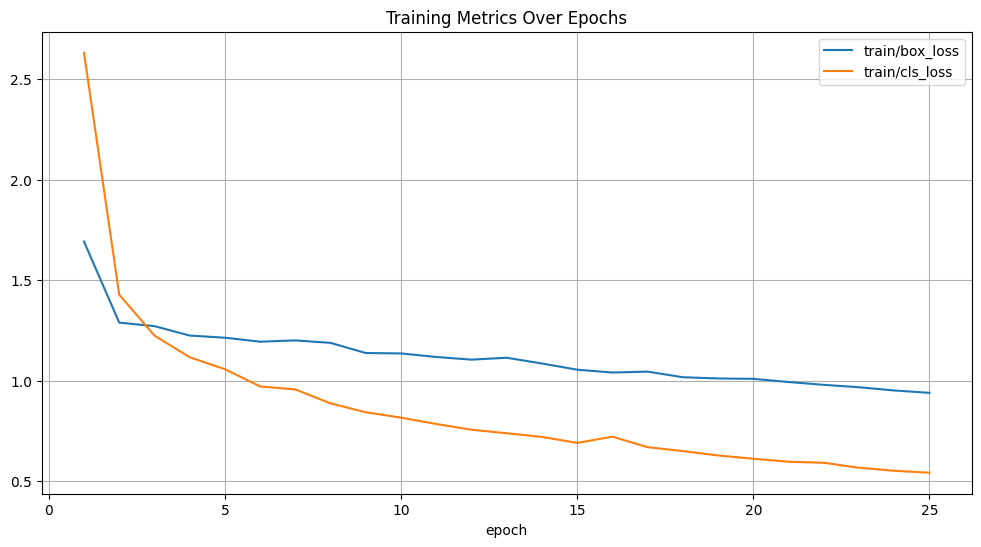

In [13]:
results_dir = "/kaggle/working/face-mask-yolov8"
training_results = pd.read_csv(os.path.join(results_dir, "results.csv"))

# Remove any unwanted leading/trailing spaces in column names
training_results.columns = training_results.columns.str.strip()

# Print column names for debugging
print("Available columns:", training_results.columns.tolist())

# Select and plot existing metrics
columns_to_plot = ['epoch', 'train/box_loss', 'train/cls_loss', 'metrics/mAP_0.5']
columns_existing = [col for col in columns_to_plot if col in training_results.columns]

if 'epoch' in training_results.columns and len(columns_existing) > 1:
    training_results[columns_existing].plot(
        x='epoch',
        figsize=(12, 6),
        title="Training Metrics Over Epochs"
    )
    plt.grid()
    plt.show()
else:
    print("Some expected columns are missing. Cannot plot.")
